In [2]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime as dt
import xgboost as xgb

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesClassifier
from sklearn.svm import SVR
from scipy.stats import randint, uniform

In [2]:
# Residue from running it on Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [42]:
data_model = pd.read_csv("data_model.csv")

In [4]:
data_model.shape

(20414, 38)

In [ ]:
data_model.head(4)

,object_id,date,hour,month,weekday,laf005_per_hour,laf01_per_hour,laf05_per_hour,laf10_per_hour,laf25_per_hour,...,LC_RAD,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_RAD60,LC_TEMP_QCL0,LC_TEMP_QCL1,LC_TEMP_QCL2,LC_TEMP_QCL3
0,255439,2022-01-04,0,1,Tue,77.2,75.4,70.8,68.9,66.0,...,0.042629,0.000632,0.001512,-13.325044,0.38135,0.042629,7.712096,7.712096,7.699641,7.735827
1,255440,2022-01-04,0,1,Tue,77.8,75.3,67.9,64.8,60.1,...,0.042629,0.000632,0.001512,-13.325044,0.38135,0.042629,7.712096,7.712096,7.699641,7.735827
2,255441,2022-01-04,0,1,Tue,76.8,73.0,66.6,63.7,59.6,...,0.042629,0.000632,0.001512,-13.325044,0.38135,0.042629,7.712096,7.712096,7.699641,7.735827
3,255442,2022-01-04,0,1,Tue,82.5,78.0,67.6,64.3,59.0,...,0.042629,0.000632,0.001512,-13.325044,0.38135,0.042629,7.712096,7.712096,7.699641,7.735827


In [43]:
## split train, test data
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(data_model, test_size=0.2, random_state = 7)

In [44]:
train_df.shape

(16331, 38)

In [45]:
train_df.head(3)

,object_id,date,hour,month,weekday,laf005_per_hour,laf01_per_hour,laf05_per_hour,laf10_per_hour,laf25_per_hour,...,LC_RAD,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_RAD60,LC_TEMP_QCL0,LC_TEMP_QCL1,LC_TEMP_QCL2,LC_TEMP_QCL3
4245,255439,2022-05-07,7,5,Sat,70.2,67.0,60.7,55.7,50.4,...,149.994700,0.000004,0.000615,-24.371025,0.080636,113.872792,13.722915,13.725348,13.715468,13.466882
19974,255442,2022-12-05,16,12,Mon,73.4,71.2,66.3,64.1,60.0,...,0.029851,0.000068,0.009765,-5.610282,0.008972,0.134328,3.148358,3.148966,3.157199,3.130750
6460,255439,2022-06-20,20,6,Mon,71.3,69.7,64.9,62.0,56.7,...,0.168040,0.000000,0.000891,-2.566722,0.041647,10.042834,16.468155,16.468155,16.472921,16.318996


## process independent variable

In [46]:
target_variable = [col for col in train_df.columns if col.startswith("laf")]
target_variable

['laf005_per_hour',
 'laf01_per_hour',
 'laf05_per_hour',
 'laf10_per_hour',
 'laf25_per_hour',
 'laf50_per_hour',
 'laf75_per_hour',
 'laf90_per_hour',
 'laf95_per_hour',
 'laf98_per_hour',
 'laf99_per_hour',
 'laf995_per_hour']

In [47]:
y_train = train_df[target_variable]
y_train.head(2)

,laf005_per_hour,laf01_per_hour,laf05_per_hour,laf10_per_hour,laf25_per_hour,laf50_per_hour,laf75_per_hour,laf90_per_hour,laf95_per_hour,laf98_per_hour,laf99_per_hour,laf995_per_hour
4245,70.2,67.0,60.7,55.7,50.4,45.9,42.2,39.5,38.4,37.3,36.7,36.2
19974,73.4,71.2,66.3,64.1,60.0,55.2,51.3,48.9,47.6,46.4,45.6,45.0


In [48]:
y_val = val_df[target_variable]
y_val.head(2)

,laf005_per_hour,laf01_per_hour,laf05_per_hour,laf10_per_hour,laf25_per_hour,laf50_per_hour,laf75_per_hour,laf90_per_hour,laf95_per_hour,laf98_per_hour,laf99_per_hour,laf995_per_hour
17150,74.3,72.9,67.4,65.3,61.1,55.1,49.9,47.2,46.3,45.7,45.4,45.2
5955,74.1,72.8,67.6,64.5,59.0,54.2,50.8,48.2,46.8,45.6,44.7,43.8


In [97]:
X_train = train_df.drop(target_variable + ["object_id","date", 'Month', 'Hour',"HM_voice_shout","HM_voice_sing","MS_non_amplified",
                                           "NE_wind","TR_passenger_car","TR_siren","LC_n","LC_WINDDIR"], axis = 1)
X_val = val_df.drop(target_variable + ["object_id","date", 'Month', 'Hour',"HM_voice_shout","HM_voice_sing","MS_non_amplified",
                                           "NE_wind","TR_passenger_car","TR_siren","LC_n","LC_WINDDIR"], axis = 1)

In [55]:
X_train.columns

Index(['hour', 'month', 'weekday', 'LC_HUMIDITY', 'LC_DWPTEMP', 'LC_RAD',
       'LC_RAININ', 'LC_DAILYRAIN', 'LC_WINDSPEED', 'LC_RAD60', 'LC_TEMP_QCL0',
       'LC_TEMP_QCL1', 'LC_TEMP_QCL2', 'LC_TEMP_QCL3'],
      dtype='object')

In [98]:
one_hot_var = ["hour", "month", "weekday"]
numerical_var = [col for col in X_train.columns if col not in one_hot_var]

In [99]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import pickle 

t = ColumnTransformer(
    transformers = [
        ('OneHot', OneHotEncoder(handle_unknown='ignore'), one_hot_var),
        ('StandardScaler', StandardScaler(), numerical_var), 
        
    ] )

# fit the encoder
t.fit(X_train, y_train)


In [103]:
t.get_feature_names_out()

array(['OneHot__hour_0', 'OneHot__hour_1', 'OneHot__hour_2',
       'OneHot__hour_3', 'OneHot__hour_4', 'OneHot__hour_5',
       'OneHot__hour_6', 'OneHot__hour_7', 'OneHot__hour_8',
       'OneHot__hour_9', 'OneHot__hour_10', 'OneHot__hour_11',
       'OneHot__hour_12', 'OneHot__hour_13', 'OneHot__hour_14',
       'OneHot__hour_15', 'OneHot__hour_16', 'OneHot__hour_17',
       'OneHot__hour_18', 'OneHot__hour_19', 'OneHot__hour_20',
       'OneHot__hour_21', 'OneHot__hour_22', 'OneHot__hour_23',
       'OneHot__month_1', 'OneHot__month_2', 'OneHot__month_3',
       'OneHot__month_4', 'OneHot__month_5', 'OneHot__month_6',
       'OneHot__month_7', 'OneHot__month_8', 'OneHot__month_9',
       'OneHot__month_10', 'OneHot__month_11', 'OneHot__month_12',
       'OneHot__weekday_Fri', 'OneHot__weekday_Mon',
       'OneHot__weekday_Sat', 'OneHot__weekday_Sun',
       'OneHot__weekday_Thu', 'OneHot__weekday_Tue',
       'OneHot__weekday_Wed', 'StandardScaler__LC_HUMIDITY',
       'StandardSca

In [105]:
# create pandas DataFrame from dense matrix
# To array because we may run into version troubles otherwise
X_train = pd.DataFrame(t.transform(X_train).toarray(), columns=t.get_feature_names_out())

X_val = pd.DataFrame(t.transform(X_val).toarray(), columns=t.get_feature_names_out())

In [106]:
X_train.columns

Index(['OneHot__hour_0', 'OneHot__hour_1', 'OneHot__hour_2', 'OneHot__hour_3',
       'OneHot__hour_4', 'OneHot__hour_5', 'OneHot__hour_6', 'OneHot__hour_7',
       'OneHot__hour_8', 'OneHot__hour_9', 'OneHot__hour_10',
       'OneHot__hour_11', 'OneHot__hour_12', 'OneHot__hour_13',
       'OneHot__hour_14', 'OneHot__hour_15', 'OneHot__hour_16',
       'OneHot__hour_17', 'OneHot__hour_18', 'OneHot__hour_19',
       'OneHot__hour_20', 'OneHot__hour_21', 'OneHot__hour_22',
       'OneHot__hour_23', 'OneHot__month_1', 'OneHot__month_2',
       'OneHot__month_3', 'OneHot__month_4', 'OneHot__month_5',
       'OneHot__month_6', 'OneHot__month_7', 'OneHot__month_8',
       'OneHot__month_9', 'OneHot__month_10', 'OneHot__month_11',
       'OneHot__month_12', 'OneHot__weekday_Fri', 'OneHot__weekday_Mon',
       'OneHot__weekday_Sat', 'OneHot__weekday_Sun', 'OneHot__weekday_Thu',
       'OneHot__weekday_Tue', 'OneHot__weekday_Wed',
       'StandardScaler__LC_HUMIDITY', 'StandardScaler__LC_DWPTEM

In [82]:
y_train.columns

Index(['laf005_per_hour', 'laf01_per_hour', 'laf05_per_hour', 'laf10_per_hour',
       'laf25_per_hour', 'laf50_per_hour', 'laf75_per_hour', 'laf90_per_hour',
       'laf95_per_hour', 'laf98_per_hour', 'laf99_per_hour',
       'laf995_per_hour'],
      dtype='object')

## First Tree Model

In [ ]:
## grid search cross validation

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold

# Define the parameter grid to search over
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [2, 5, 10, 30],
    'min_samples_leaf': [10, 20, 30]
}

rf_model = RandomForestRegressor()

kf = KFold(n_splits=5, shuffle=True, random_state=7 )

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=kf, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train["laf50_per_hour"])

# Print the best hyperparameters and corresponding mean score
print("Best parameters:", grid_search.best_params_)
print("Best score:", (-grid_search.best_score_)**0.5)

'''
Best parameters: {'max_depth': 30, 'min_samples_leaf': 10, 'n_estimators': 300}
Best score: 3.289151450103886
'''

In [ ]:
from sklearn.ensemble import RandomForestRegressor
tree_model = RandomForestRegressor(n_estimators=300, max_depth=30, criterion = "squared_error",
                             min_samples_leaf = 10,
                             random_state=7)
tree_model.fit(X_train, y_train["laf50_per_hour"])

RandomForestRegressor(max_depth=30, min_samples_leaf=10, n_estimators=300,
                      random_state=7)

In [ ]:
import math
import sklearn.metrics
pred_train_tree = tree_model.predict(X_val)



Text(0, 0.5, 'y val')

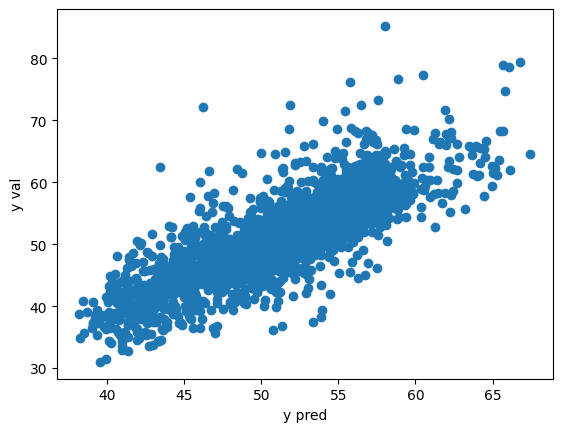

In [ ]:
plt.scatter(pred_train_tree, y_val["laf50_per_hour"])
plt.xlabel('y pred')
plt.ylabel('y val')

In [ ]:
math.sqrt(sklearn.metrics.mean_squared_error(pred_train_tree, y_val["laf50_per_hour"]))


3.189054434621591

In [ ]:
X_val.shape

(4083, 69)

In [ ]:
X_train.shape

(16331, 69)

## Predict laf_50

In [84]:
excluded_variable  = [ 'StandardScaler__HM_voice_shout',
 'StandardScaler__HM_voice_sing',
 'StandardScaler__MS_non_amplified',
 'StandardScaler__NE_wind',
 'StandardScaler__TR_passenger_car',
 'StandardScaler__TR_siren', "StandardScaler__LC_n"]

select_variable = [col for col in X_train.columns if col not in excluded_variable]

In [85]:
select_variable

['OneHot__hour_0',
 'OneHot__hour_1',
 'OneHot__hour_2',
 'OneHot__hour_3',
 'OneHot__hour_4',
 'OneHot__hour_5',
 'OneHot__hour_6',
 'OneHot__hour_7',
 'OneHot__hour_8',
 'OneHot__hour_9',
 'OneHot__hour_10',
 'OneHot__hour_11',
 'OneHot__hour_12',
 'OneHot__hour_13',
 'OneHot__hour_14',
 'OneHot__hour_15',
 'OneHot__hour_16',
 'OneHot__hour_17',
 'OneHot__hour_18',
 'OneHot__hour_19',
 'OneHot__hour_20',
 'OneHot__hour_21',
 'OneHot__hour_22',
 'OneHot__hour_23',
 'OneHot__month_1',
 'OneHot__month_2',
 'OneHot__month_3',
 'OneHot__month_4',
 'OneHot__month_5',
 'OneHot__month_6',
 'OneHot__month_7',
 'OneHot__month_8',
 'OneHot__month_9',
 'OneHot__month_10',
 'OneHot__month_11',
 'OneHot__month_12',
 'OneHot__weekday_Fri',
 'OneHot__weekday_Mon',
 'OneHot__weekday_Sat',
 'OneHot__weekday_Sun',
 'OneHot__weekday_Thu',
 'OneHot__weekday_Tue',
 'OneHot__weekday_Wed',
 'StandardScaler__LC_HUMIDITY',
 'StandardScaler__LC_DWPTEMP',
 'StandardScaler__LC_RAD',
 'StandardScaler__LC_RAININ',

In [86]:
## grid search cross validation (excluding sound variables)

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold

# Define the parameter grid to search over
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [2, 5, 10, 30],
    'min_samples_leaf': [10, 20, 30]
}

rf_model = RandomForestRegressor()

kf = KFold(n_splits=5, shuffle=True, random_state=7 )

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=kf, scoring='neg_mean_squared_error')

grid_search.fit(X_train[select_variable], y_train["laf50_per_hour"])

# Print the best hyperparameters and corresponding mean score
print("Best parameters:", grid_search.best_params_)
print("Best score:", (-grid_search.best_score_)**0.5)

'''
Best parameters: {'max_depth': 30, 'min_samples_leaf': 10, 'n_estimators': 300}
Best score: 3.6002069030220243
\nBest parameters: {'max_depth': 30, 'min_samples_leaf': 10, 'n_estimators': 300}\nBest score: 3.2866983117233812\n\nBest parameters: {'max_depth': 30, 'min_samples_leaf': 10, 'n_estimators': 300}\nBest score: 3.289151450103886\n\n
'''

KeyboardInterrupt: 

In [87]:
X_train[select_variable]

,OneHot__hour_0,OneHot__hour_1,OneHot__hour_2,OneHot__hour_3,OneHot__hour_4,OneHot__hour_5,OneHot__hour_6,OneHot__hour_7,OneHot__hour_8,OneHot__hour_9,...,StandardScaler__LC_DWPTEMP,StandardScaler__LC_RAD,StandardScaler__LC_RAININ,StandardScaler__LC_DAILYRAIN,StandardScaler__LC_WINDSPEED,StandardScaler__LC_RAD60,StandardScaler__LC_TEMP_QCL0,StandardScaler__LC_TEMP_QCL1,StandardScaler__LC_TEMP_QCL2,StandardScaler__LC_TEMP_QCL3
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.371451,0.298191,-0.165229,-0.195511,-0.653386,0.054244,-0.050247,-0.049607,-0.051128,-0.054367
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.098942,-0.743654,-0.070931,2.186042,-0.885570,-0.741668,-1.399241,-1.399244,-1.398033,-1.417263
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.274476,-0.742694,-0.170399,-0.123560,-0.779704,-0.672331,0.299963,0.300399,0.300636,0.321706
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.370736,-0.743373,-0.170399,-0.355547,-0.594279,-0.742117,-0.310654,-0.311074,-0.309907,-0.287871
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.296508,-0.743559,-0.170399,-0.345487,-0.911924,-0.742270,-0.788365,-0.788259,-0.786665,-0.771995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16326,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.893999,0.090527,-0.170399,-0.352986,-0.043427,0.446469,0.681738,0.679602,0.680559,0.688344
16327,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.320259,-0.029517,-0.170399,-0.338873,0.234888,0.505829,-0.859404,-0.860929,-0.862518,-0.899033
16328,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.980319,-0.743540,-0.170399,-0.355547,-0.890860,-0.742296,0.178241,0.178641,0.178900,0.235621
16329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.986453,1.554361,-0.170399,-0.355547,0.785747,2.001434,1.688960,1.687347,1.687319,1.659991


In [ ]:
from sklearn.ensemble import RandomForestRegressor
tree_laf50 = RandomForestRegressor(n_estimators=300, max_depth=30, criterion = "squared_error",
                             min_samples_leaf = 10,
                             random_state=7)
tree_laf50.fit(X_train[select_variable], y_train["laf50_per_hour"])

RandomForestRegressor(max_depth=30, min_samples_leaf=10, n_estimators=300,
                      random_state=7)

In [ ]:
import math
import sklearn.metrics
pred_laf50 = tree_laf50.predict(X_val[select_variable])


Text(0, 0.5, 'y val')

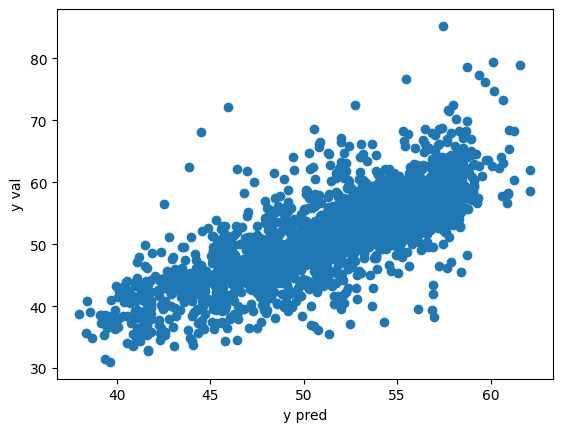

In [ ]:
plt.scatter(pred_laf50, y_val["laf50_per_hour"])
plt.xlabel('y pred')
plt.ylabel('y val')

In [ ]:
math.sqrt(sklearn.metrics.mean_squared_error(pred_laf50, y_val["laf50_per_hour"]))


3.500027609151924

<BarContainer object of 30 artists>

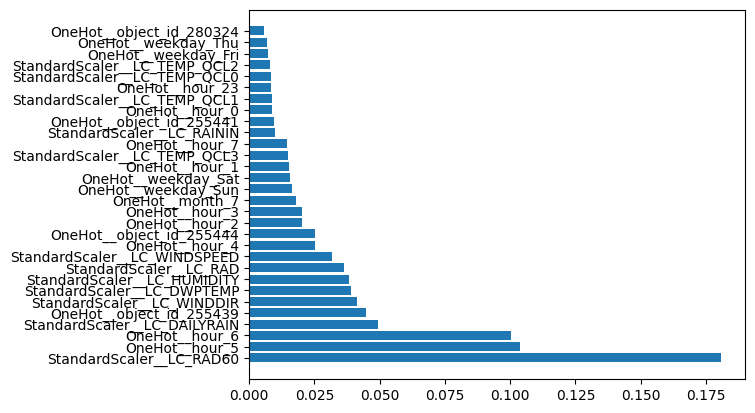

In [ ]:
feature_importances = tree_laf50.feature_importances_
sorted_idx = feature_importances.argsort()[::-1]
sorted_importances = feature_importances[sorted_idx[0:30]]
sorted_columns = list(X_train[select_variable].columns[sorted_idx[0:30]])
plt.barh(sorted_columns, sorted_importances)

In [24]:
X_train[select_variable].columns

Index(['OneHot__hour_0', 'OneHot__hour_1', 'OneHot__hour_2', 'OneHot__hour_3',
       'OneHot__hour_4', 'OneHot__hour_5', 'OneHot__hour_6', 'OneHot__hour_7',
       'OneHot__hour_8', 'OneHot__hour_9', 'OneHot__hour_10',
       'OneHot__hour_11', 'OneHot__hour_12', 'OneHot__hour_13',
       'OneHot__hour_14', 'OneHot__hour_15', 'OneHot__hour_16',
       'OneHot__hour_17', 'OneHot__hour_18', 'OneHot__hour_19',
       'OneHot__hour_20', 'OneHot__hour_21', 'OneHot__hour_22',
       'OneHot__hour_23', 'OneHot__month_1', 'OneHot__month_2',
       'OneHot__month_3', 'OneHot__month_4', 'OneHot__month_5',
       'OneHot__month_6', 'OneHot__month_7', 'OneHot__month_8',
       'OneHot__month_9', 'OneHot__month_10', 'OneHot__month_11',
       'OneHot__month_12', 'OneHot__weekday_Fri', 'OneHot__weekday_Mon',
       'OneHot__weekday_Sat', 'OneHot__weekday_Sun', 'OneHot__weekday_Thu',
       'OneHot__weekday_Tue', 'OneHot__weekday_Wed',
       'StandardScaler__LC_HUMIDITY', 'StandardScaler__LC_DWPTEM

In [88]:
import xgboost

# Define the model parameters
model_params = {
    'random_forest': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': randint(50, 100),
            'max_depth': randint(3, 50),
            'max_features': ['auto', 'sqrt'],
            'min_samples_split': randint(2, 20),
            'min_samples_leaf': randint(1, 10),
            'bootstrap': [True, False]
        }
    },
    'gradient_boosting': {
        'model': GradientBoostingRegressor(),
        'params': {
            'n_estimators': randint(50, 100),
            'learning_rate': uniform(0.01, 0.5),
            'max_depth': randint(1, 10),
            'min_samples_split': randint(2, 20),
            'min_samples_leaf': randint(1, 10)
        }
    },
    
    'xgboost': {
        'model': xgboost.XGBRegressor(),
        'params': {
            'n_estimators': randint(50, 100),
            'learning_rate': uniform(0.01, 0.5),
            'max_depth': randint(1, 10),
            'min_child_weight': randint(1, 10),
            'gamma': uniform(0, 1),
            'reg_alpha': uniform(0, 1),
            'reg_lambda': uniform(0, 1),
        }
    }
    
}

params_dict = {}

# Loop through each model in model_params and run RandomizedSearchCV
for model_name, model_info in model_params.items():
    print("Running RandomizedSearchCV for {}...".format(model_name))
    
    # Create a RandomizedSearchCV object for the current model
    model = model_info['model']
    param_dist = model_info['params']
    random_search = RandomizedSearchCV(model, param_distributions=param_dist,
                                       n_iter=10, cv=5, n_jobs=1, random_state=7)
    
    # Fit the RandomizedSearchCV object to the data
    random_search.fit(X_train[select_variable], y_train["laf50_per_hour"])
    
    # Print the best parameters and score
    params_dict[model_name] = random_search.best_params_
    print("Best parameters for {}: ".format(model_name), random_search.best_params_)
    print("Best score for {}: ".format(model_name), random_search.best_score_)
    print("\n")

Running RandomizedSearchCV for random_forest...
Best parameters for random_forest:  {'bootstrap': False, 'max_depth': 26, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 69}
Best score for random_forest:  0.5397290282132664


Running RandomizedSearchCV for gradient_boosting...
Best parameters for gradient_boosting:  {'learning_rate': 0.1442194900509356, 'max_depth': 8, 'min_samples_leaf': 7, 'min_samples_split': 6, 'n_estimators': 98}
Best score for gradient_boosting:  0.5484848806126156


Running RandomizedSearchCV for xgboost...
Best parameters for xgboost:  {'gamma': 0.482636902412518, 'learning_rate': 0.3168517348631646, 'max_depth': 8, 'min_child_weight': 8, 'n_estimators': 60, 'reg_alpha': 0.27651470778821396, 'reg_lambda': 0.44650589502340177}
Best score for xgboost:  0.5417342909167582




In [89]:
from sklearn.metrics import mean_absolute_error
gb_params = params_dict['gradient_boosting']

gb = GradientBoostingRegressor(**gb_params, random_state=7)

gb.fit(X_train[select_variable], y_train["laf50_per_hour"])

train_preds = gb.predict(X_train[select_variable])
val_preds = gb.predict(X_val[select_variable])

print("Train RMSE:", np.sqrt(mean_squared_error(train_preds, y_train["laf50_per_hour"])))
print("Val RMSE:", np.sqrt(mean_squared_error(val_preds, y_val["laf50_per_hour"])))
print("Train MAE:", mean_absolute_error(train_preds, y_train["laf50_per_hour"]))
print("Val MAE:", mean_absolute_error(val_preds, y_val["laf50_per_hour"]))


Train RMSE: 2.875911088446612
Val RMSE: 3.6074754843353434
Train MAE: 1.9123372651832244
Val MAE: 2.373380781162513


In [90]:
rf_params = params_dict['random_forest']

rf = RandomForestRegressor(**rf_params, random_state=7)

rf.fit(X_train[select_variable], y_train["laf50_per_hour"])

train_preds = rf.predict(X_train[select_variable])
val_preds = rf.predict(X_val[select_variable])

print("Train RMSE:", np.sqrt(mean_squared_error(train_preds, y_train["laf50_per_hour"])))
print("Val RMSE:", np.sqrt(mean_squared_error(val_preds, y_val["laf50_per_hour"])))
print("Train MAE:", mean_absolute_error(train_preds, y_train["laf50_per_hour"]))
print("Val MAE:", mean_absolute_error(val_preds, y_val["laf50_per_hour"]))

Train RMSE: 2.7870375091775745
Val RMSE: 3.6056668628681843
Train MAE: 1.8312082279249757
Val MAE: 2.3562641992210787


In [94]:
import xgboost

xgb_params = params_dict['xgboost']

xgb = xgboost.XGBRegressor(**xgb_params, random_state=7)

xgb.fit(X_train[select_variable], y_train["laf50_per_hour"])

train_preds = xgb.predict(X_train[select_variable])
val_preds = xgb.predict(X_val[select_variable])


print("Train RMSE:", np.sqrt(mean_squared_error(train_preds, y_train["laf50_per_hour"])))
print("Val RMSE:", np.sqrt(mean_squared_error(val_preds, y_val["laf50_per_hour"])))
print("Train MAE:", mean_absolute_error(train_preds, y_train["laf50_per_hour"]))
print("Val MAE:", mean_absolute_error(val_preds, y_val["laf50_per_hour"]))


Train RMSE: 2.779932414889992
Val RMSE: 3.594638945581137
Train MAE: 1.850290582012279
Val MAE: 2.37758618442854


In [92]:
import pickle
pickle.dump(xgb, open("xgb_50.sav","wb"))
pickle.dump(rf,open("rf_50.sav","wb"))
pickle.dump(gb,open("gb_50.sav","wb"))


In [93]:
X_train.columns

Index(['OneHot__hour_0', 'OneHot__hour_1', 'OneHot__hour_2', 'OneHot__hour_3',
       'OneHot__hour_4', 'OneHot__hour_5', 'OneHot__hour_6', 'OneHot__hour_7',
       'OneHot__hour_8', 'OneHot__hour_9', 'OneHot__hour_10',
       'OneHot__hour_11', 'OneHot__hour_12', 'OneHot__hour_13',
       'OneHot__hour_14', 'OneHot__hour_15', 'OneHot__hour_16',
       'OneHot__hour_17', 'OneHot__hour_18', 'OneHot__hour_19',
       'OneHot__hour_20', 'OneHot__hour_21', 'OneHot__hour_22',
       'OneHot__hour_23', 'OneHot__month_1', 'OneHot__month_2',
       'OneHot__month_3', 'OneHot__month_4', 'OneHot__month_5',
       'OneHot__month_6', 'OneHot__month_7', 'OneHot__month_8',
       'OneHot__month_9', 'OneHot__month_10', 'OneHot__month_11',
       'OneHot__month_12', 'OneHot__weekday_Fri', 'OneHot__weekday_Mon',
       'OneHot__weekday_Sat', 'OneHot__weekday_Sun', 'OneHot__weekday_Thu',
       'OneHot__weekday_Tue', 'OneHot__weekday_Wed',
       'StandardScaler__LC_HUMIDITY', 'StandardScaler__LC_DWPTEM

# Neuer Abschnitt

Text(0, 0.5, 'y val')

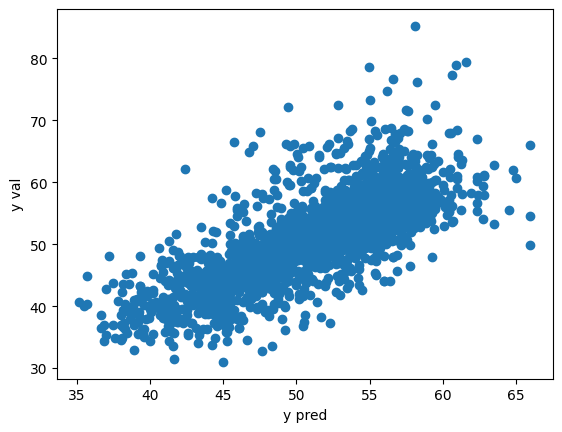

In [95]:
plt.scatter(val_preds, y_val["laf50_per_hour"])
plt.xlabel('y pred')
plt.ylabel('y val')

## predict laf25

In [ ]:
## grid search cross validation (excluding sound variables)

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold

# Define the parameter grid to search over
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [2, 5, 10, 30],
    'min_samples_leaf': [10, 20, 30]
}

rf_model = RandomForestRegressor()

kf = KFold(n_splits=5, shuffle=True, random_state=7 )

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=kf, scoring='neg_mean_squared_error')

grid_search.fit(X_train[select_variable], y_train["laf25_per_hour"])

# Print the best hyperparameters and corresponding mean score
print("Best parameters:", grid_search.best_params_)
print("Best score:", (-grid_search.best_score_)**0.5)


In [ ]:
from sklearn.ensemble import RandomForestRegressor
tree_laf25 = RandomForestRegressor(n_estimators=300, max_depth=30, criterion = "squared_error",
                             min_samples_leaf = 10,
                             random_state=7)
tree_laf25.fit(X_train[select_variable], y_train["laf25_per_hour"])

RandomForestRegressor(max_depth=30, min_samples_leaf=10, n_estimators=300,
                      random_state=7)

In [ ]:
import math
import sklearn.metrics
pred_laf25 = tree_laf25.predict(X_val[select_variable])

Text(0, 0.5, 'y val')

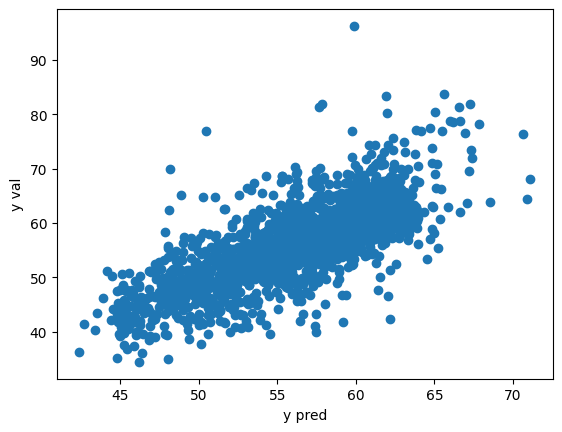

In [ ]:
plt.scatter(pred_laf25, y_val["laf25_per_hour"])
plt.xlabel('y pred')
plt.ylabel('y val')

<BarContainer object of 30 artists>

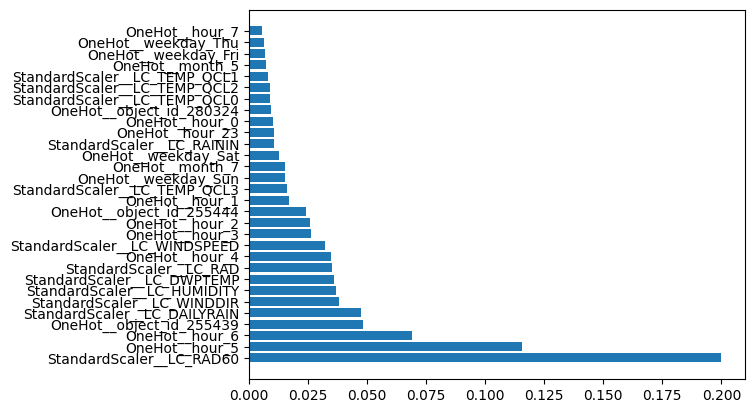

In [ ]:
feature_importances = tree_laf25.feature_importances_
sorted_idx = feature_importances.argsort()[::-1]
sorted_importances = feature_importances[sorted_idx[0:30]]
sorted_columns = list(X_train[select_variable].columns[sorted_idx[0:30]])
plt.barh(sorted_columns, sorted_importances)

In [ ]:
math.sqrt(sklearn.metrics.mean_squared_error(pred_laf25, y_val["laf25_per_hour"]))


3.484457119039357

## predict laf75

In [ ]:
## grid search cross validation (excluding sound variables)

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold

# Define the parameter grid to search over
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [2, 5, 10, 30],
    'min_samples_leaf': [10, 20, 30]
}

rf_model = RandomForestRegressor()

kf = KFold(n_splits=5, shuffle=True, random_state=7 )

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=kf, scoring='neg_mean_squared_error')

grid_search.fit(X_train[select_variable], y_train["laf75_per_hour"])
plt.scatter(pred_laf25, y_val["laf25_per_hour"])
plt.xlabel('y pred')
plt.ylabel('y val')
# Print the best hyperparameters and corresponding mean score
print("Best parameters:", grid_search.best_params_)
print("Best score:", (-grid_search.best_score_)**0.5)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
tree_laf75 = RandomForestRegressor(n_estimators=300, max_depth=30, criterion = "squared_error",
                             min_samples_leaf = 10,
                             random_state=7)
tree_laf75.fit(X_train[select_variable], y_train["laf75_per_hour"])

RandomForestRegressor(max_depth=30, min_samples_leaf=10, n_estimators=300,
                      random_state=7)

In [ ]:
import math
import sklearn.metrics
pred_laf75 = tree_laf75.predict(X_val[select_variable])

Text(0, 0.5, 'y val')

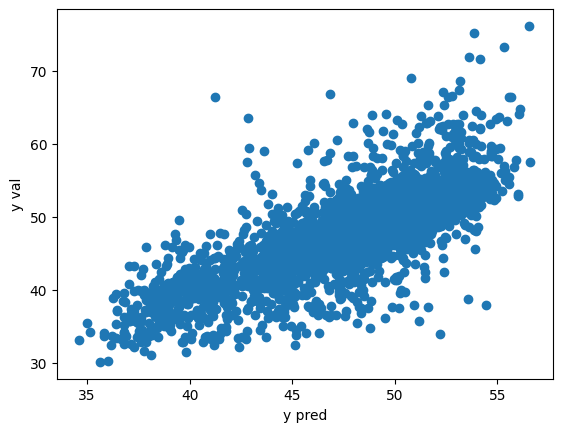

In [ ]:
plt.scatter(pred_laf75, y_val["laf75_per_hour"])
plt.xlabel('y pred')
plt.ylabel('y val')

In [ ]:
math.sqrt(sklearn.metrics.mean_squared_error(pred_laf75, y_val["laf75_per_hour"]))


3.41267507310803

In [ ]:
y_val.loc[y_val.laf75_per_hour < y_val.laf25_per_hour]

,laf005_per_hour,laf01_per_hour,laf05_per_hour,laf10_per_hour,laf25_per_hour,laf50_per_hour,laf75_per_hour,laf90_per_hour,laf95_per_hour,laf98_per_hour,laf99_per_hour,laf995_per_hour
17150,74.3,72.9,67.4,65.3,61.1,55.1,49.9,47.2,46.3,45.7,45.4,45.2
5955,74.1,72.8,67.6,64.5,59.0,54.2,50.8,48.2,46.8,45.6,44.7,43.8
18026,69.2,66.7,61.5,59.1,54.6,49.5,46.7,45.4,44.9,44.4,44.1,43.9
5524,72.6,70.3,64.0,61.5,56.8,51.7,47.9,45.2,43.9,42.5,41.7,40.8
1169,70.0,66.8,60.1,56.1,49.2,45.4,44.3,43.6,43.3,43.0,42.7,42.5
...,...,...,...,...,...,...,...,...,...,...,...,...
19031,68.6,66.7,60.3,56.5,50.4,46.1,44.9,44.1,43.8,43.4,43.2,43.0
12747,72.3,71.2,66.4,63.7,59.8,54.9,49.7,46.0,44.0,41.8,40.8,40.2
3214,68.9,67.1,62.6,60.5,56.6,51.2,46.2,41.8,39.6,37.7,36.7,36.0
962,74.4,71.4,64.8,61.4,55.2,49.3,44.2,40.6,38.9,37.4,36.7,36.0
